## 1-1,结构化数据建模流程范例
一，准备数据
titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,417,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.5000,NaN,S
96,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S
97,364,0,3,"Asim, Mr. Adola",male,35.0,0,0,SOTON/O.Q. 3101310,7.0500,NaN,S
98,506,0,1,"Penasco y Castellana, Mr. Victor de Satode",male,18.0,1,0,PC 17758,108.9000,C65,C


字段说明：

Survived:0代表死亡，1代表存活【y标签】
Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
Name:乘客姓名 【舍去】
Sex:乘客性别 【转换成bool特征】
Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
Parch:乘客父母/孩子的个数(整数值)【数值特征】
Ticket:票号(字符串)【舍去】
Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】
利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

label分布情况

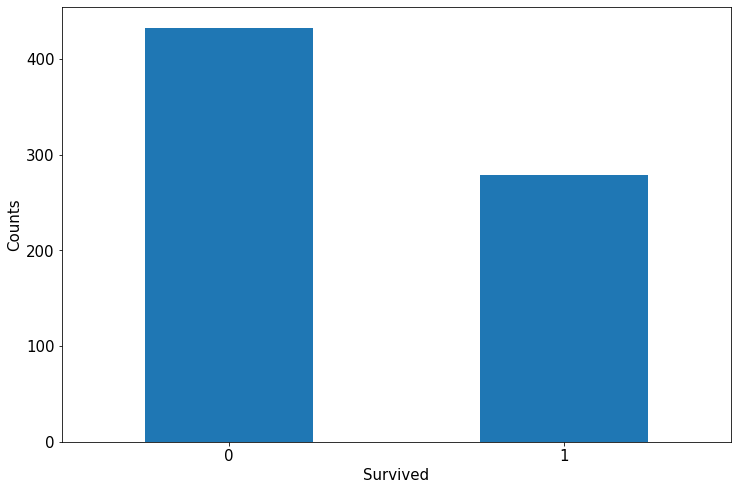

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

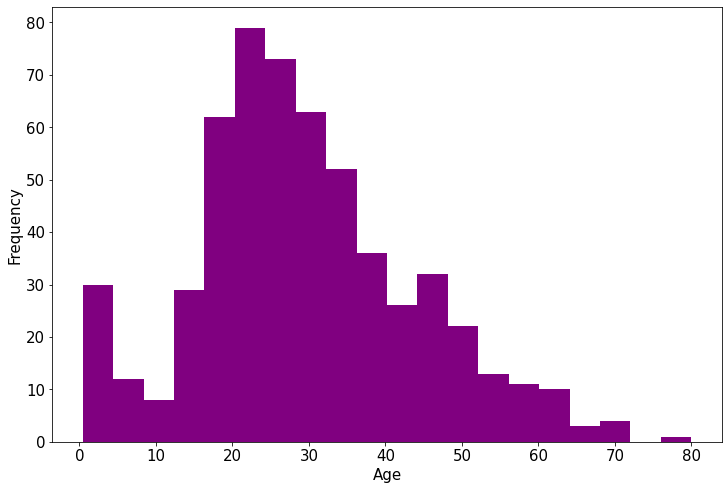

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

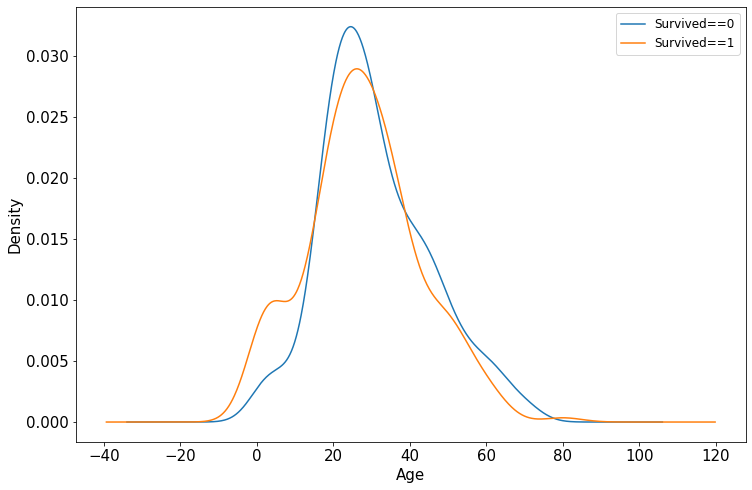

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [5]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)


二，定义模型
使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用最简单的Sequential，按层顺序模型。

In [6]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


三，训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [7]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #分割一部分训练数据用于验证
                   )

Epoch 1/30
9/9 [==============================] - 1s 24ms/step - loss: 1.7762 - auc: 0.4316 - val_loss: 1.1856 - val_auc: 0.4870
Epoch 2/30
9/9 [==============================] - 0s 2ms/step - loss: 0.7951 - auc: 0.6000 - val_loss: 0.6472 - val_auc: 0.6784
Epoch 3/30
9/9 [==============================] - 0s 2ms/step - loss: 0.6732 - auc: 0.7493 - val_loss: 0.6543 - val_auc: 0.7273
Epoch 4/30
9/9 [==============================] - 0s 2ms/step - loss: 0.5979 - auc: 0.7849 - val_loss: 0.5863 - val_auc: 0.7527
Epoch 5/30
9/9 [==============================] - 0s 2ms/step - loss: 0.5547 - auc: 0.7996 - val_loss: 0.5956 - val_auc: 0.7490
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 0.5413 - auc: 0.8046 - val_loss: 0.5897 - val_auc: 0.7459
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 0.5411 - auc: 0.7959 - val_loss: 0.5937 - val_auc: 0.7466
Epoch 8/30
9/9 [==============================] - 0s 2ms/step - loss: 0.5353 - auc: 0.8003 - val_loss: 

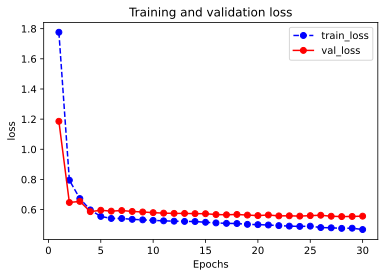

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history,"loss")

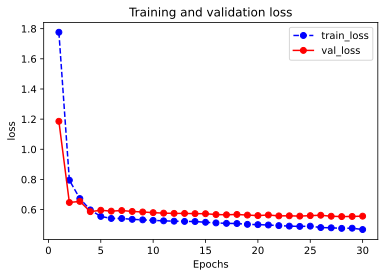

In [12]:
plot_metric(history,"loss")

In [13]:
model.evaluate(x = x_test,y = y_test)

6/6 [==============================] - 0s 800us/step - loss: 0.4668 - auc: 0.8417


[0.4667797088623047, 0.8416804075241089]

## 五，使用模型

In [14]:
#预测概率
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #等价写法

array([[0.20934239],
       [0.41178465],
       [0.42986506],
       [0.92322445],
       [0.5533284 ],
       [0.59161556],
       [0.12957326],
       [0.7754357 ],
       [0.5382716 ],
       [0.11835039]], dtype=float32)

In [16]:
#预测类别
model.predict_classes(x_test[0:10])

AttributeError: 'Sequential' object has no attribute 'predict_classes'

## 六，保存模型
可以使用Keras方式保存模型，也可以使用TensorFlow原生方式保存。前者仅仅适合使用Python环境恢复模型，后者则可以跨平台进行模型部署。

推荐使用后一种方式进行保存。

## 1，Keras方式保存

In [19]:
# 保存模型结构及权重

model.save('./data/keras_model.h5')  

del model  #删除现有模型

# identical to the previous one
model = models.load_model('./data/keras_model.h5')
model.evaluate(x_test,y_test)

ImportError: `save_model` requires h5py.

In [20]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)

In [22]:
#保存模型权重
model.save_weights('./data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )
# 加载权重
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

ImportError: `save_weights` requires h5py when saving in hdf5.

In [23]:
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [24]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel\assets
export saved model.
6/6 [==============================] - 0s 800us/step - loss: 0.4668 - auc: 0.8417


[0.4667797088623047, 0.8416804075241089]